# CNN for MNIST digits dataset

## Importing libraries

Importing the libraries we need to build the network.

In [134]:
%matplotlib inline

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
from matplotlib import pyplot as plt

In [135]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

In [136]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

In [137]:
import warnings
warnings.filterwarnings("ignore")

## Declaring functions

In [138]:
def plt_classes_histogram(y, nb_classes):
  plt.hist(y, bins = np.linspace(min(set(y)), max(set(y))+1, num=nb_classes+1))
  plt.show()

In [139]:
def plot_history(x_plot, network_history, best_epoch=None):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0.0,0.9)
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    if best_epoch != None:
      plt.plot(best_epoch, network_history.history['val_loss'][best_epoch], marker='o')
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    if best_epoch != None:
      plt.plot(best_epoch, network_history.history['val_accuracy'][best_epoch], marker='o')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

## Loading the dataset

Loading the train and test sets of MNIST dataset.

In [140]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

##Inspecting the data

In [141]:
print("x_train shape: ", x_train.shape)

x_train shape:  (60000, 28, 28)


In [142]:
nb_classes = len(set(y_train))
print('Number of categories:',nb_classes)

Number of categories: 10


In [143]:
x_train[0].shape, x_train[0].shape[0]*x_train[0].shape[1], np.min(x_train[0]), np.max(x_train[0])

((28, 28), 784, 0, 255)

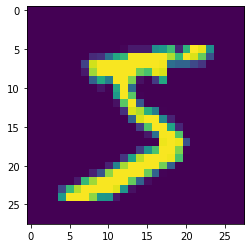

In [144]:
plt.imshow(x_train[0])

As we can see below, the dataset is quite balanced, and the distributions of train and test dataset are similiar. We won't go for a rebalancing.

In [145]:
print(dict(Counter(y_train)))
print(dict(Counter(y_test)))

{5: 5421, 0: 5923, 4: 5842, 1: 6742, 9: 5949, 2: 5958, 3: 6131, 6: 5918, 7: 6265, 8: 5851}
{7: 1028, 2: 1032, 1: 1135, 0: 980, 4: 982, 9: 1009, 5: 892, 6: 958, 3: 1010, 8: 974}


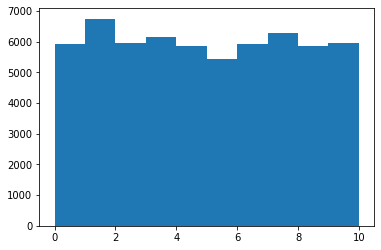

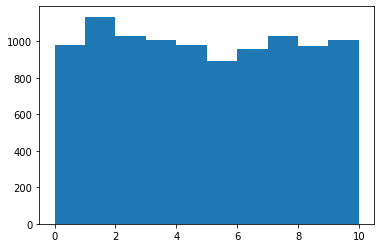

In [146]:
plt_classes_histogram(y_train, nb_classes)
plt_classes_histogram(y_test, nb_classes)

## Preparing the data

In [ ]:
seed = 0

### Data normalization

Here we perform a normalization of the data, casting images to matrix of float between 0 and 1.

In [147]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255

### Reshaping the dataset

Below we transform the shape of the dataset to 28x28x1

In [148]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
input_shape = (28,28,1)

In [149]:
print("x_train after reshape: ", X_train.shape)

x_train after reshape:  (60000, 28, 28, 1)


### Shuffle data and check good train/validation splitting

Here we shuffle the data before splitting to avoid imbalances between the training and validation set distributions.

In [150]:
Y_train = shuffle(y_train, random_state = seed)
X_train = shuffle(X_train, random_state = seed)

### Split Training and Validation Data

Since the dataset is quite populous and to reduce the differences between the training distribution and the validation distribution, we consider a validation set of 10%.


In [151]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [152]:
print('Size of the training set:', X_train.shape)
print('Size of the validation set:', X_val.shape)

Size of the training set: (54000, 28, 28, 1)
Size of the validation set: (6000, 28, 28, 1)


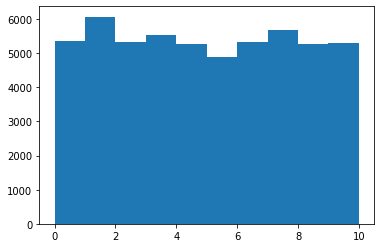

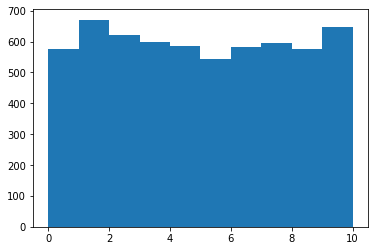

In [153]:
plt_classes_histogram(Y_train, nb_classes)
plt_classes_histogram(Y_val, nb_classes)

As we can see after the splitting both the training and the validation distributions are quite similiar. So 10% seems a good choice for a validation splitting.

### Categorization of the classes

In [154]:
Y_train =  keras.utils.to_categorical(Y_train, nb_classes)
Y_val =  keras.utils.to_categorical(Y_val, nb_classes)
Y_test =  keras.utils.to_categorical(y_test, nb_classes)

In [155]:
print("y_train shape after casting to categorical : ", Y_train.shape)

y_train shape after casting to categorical :  (54000, 10)


## Building the network

The network architecture consists of:
1.   a convolutional layer, of 8 filters with 5x5 window
2.   a max pooling layer, which reduces the output of the previous layer by a factor of 4
3.   a convolutional layer, of 16 filters with 3x3 window
4.   a max pooling layer, which reduces the output of the previous layer by a factor of 4
5.   a flatten layer, which converts the output shape of the previous layer into a flat layer, with a dropout rate of 0.3 as a regularization technique
6.   an output layer with 10 neurons totally connected to the previous layer

We have that the number of parameters for the first convolutional layer **(1)** is *((5x5)+1)x8 = 208*, as we have windows of 5x5 weights for 8 filters plus the bias parameter for the 8 filters. 

The output of this layer has a shape *(28-5+1)x(28-5+1)x8*, which is reduced by a factor of 4 by the max pooling layer **(2)**, becoming *13x13x8*.

Then we have that the number of parameters for the second convolutional layer **(3)** is *(((3x3)x8)+1)x16 = 1168*, as we have windows of 3x3 weights for 8 channels for 16 filters plus the bias parameter for the 16 filters.

The output of this layer has a shape *(13-3+1)x(13-3+1)x16*, which is reduced by a factor of 4 by the max pooling layer **(4)**, becoming *5x5x16*.

Then the flatten layer **(5)** transforms the previous *5x5x16* shape into a flat layer of *400* neurons, that is fully connected to the output layer of 10 neurons **(6)**. So the number of parameters to link those layers is *(400+1)x10 = 4010*.

The total number of parameters of the networks is then *208+1168+4010 = 5386*.


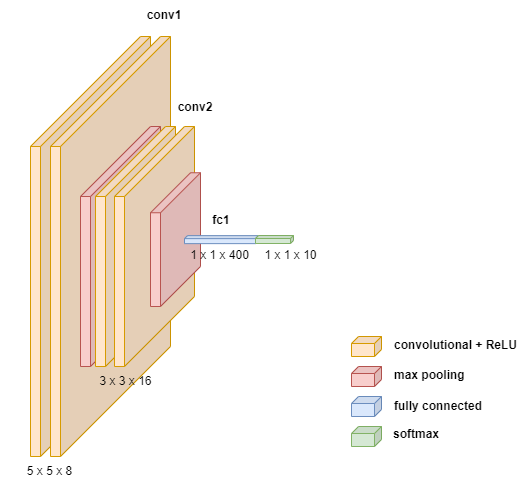

### CNN Network

Here is a list of the hyper-parameters used to tune the network:
*   optimizer: adam
*   activation function: relu 
*   output function: softmax 
*   learning rate: 0.001
*   batch size: 128
*   number of epochs: 200 (using model checkpoint to store the weights of the best epoch with lowest loss)
*   dropout rate: 30%



In [156]:
initializer = tf.keras.initializers.GlorotUniform(seed=seed) 

In [187]:
model = keras.Sequential(
    [
     keras.Input(shape=input_shape),
     layers.Conv2D(8, kernel_size=(5, 5), activation="relu", kernel_initializer=initializer),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Conv2D(16, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Flatten(),
     layers.Dropout(0.3),
     layers.Dense(nb_classes, activation="softmax")
    ]
)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

In [188]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 16)        1168      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 400)               0         
                                                                 
 dropout_12 (Dropout)        (None, 400)             

In [189]:
n_epochs = 200
batch_size = 128

best_model = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

network_history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, validation_data=(X_val, Y_val), callbacks=[best_model])

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.16668, saving model to best_model.h5
422/422 - 3s - loss: 0.5624 - accuracy: 0.8240 - val_loss: 0.1667 - val_accuracy: 0.9502 - 3s/epoch - 8ms/step
Epoch 2/200

Epoch 00002: val_loss improved from 0.16668 to 0.10981, saving model to best_model.h5
422/422 - 2s - loss: 0.1742 - accuracy: 0.9468 - val_loss: 0.1098 - val_accuracy: 0.9665 - 2s/epoch - 5ms/step
Epoch 3/200

Epoch 00003: val_loss improved from 0.10981 to 0.08706, saving model to best_model.h5
422/422 - 2s - loss: 0.1284 - accuracy: 0.9616 - val_loss: 0.0871 - val_accuracy: 0.9717 - 2s/epoch - 6ms/step
Epoch 4/200

Epoch 00004: val_loss improved from 0.08706 to 0.07368, saving model to best_model.h5
422/422 - 2s - loss: 0.1067 - accuracy: 0.9669 - val_loss: 0.0737 - val_accuracy: 0.9773 - 2s/epoch - 6ms/step
Epoch 5/200

Epoch 00005: val_loss improved from 0.07368 to 0.06996, saving model to best_model.h5
422/422 - 2s - loss: 0.0960 - accuracy: 0.9710 - val_loss: 0.0700

## Analyze and comment the training results

### Plotting accuracy/loss graphs

In [193]:
best_epoch = 72

In [194]:
print('history dict:', network_history.history)

history dict: {'loss': [0.5624433755874634, 0.17420890927314758, 0.1283891648054123, 0.10666550695896149, 0.09602024406194687, 0.08816683292388916, 0.08203800767660141, 0.07576458156108856, 0.07048496603965759, 0.06769175082445145, 0.06591309607028961, 0.06417600065469742, 0.06224632263183594, 0.0585843063890934, 0.0574546754360199, 0.05421997234225273, 0.055741146206855774, 0.05285729840397835, 0.051127638667821884, 0.05255194380879402, 0.049939315766096115, 0.049200937151908875, 0.04895491525530815, 0.04573788493871689, 0.045929525047540665, 0.046874288469552994, 0.04464131221175194, 0.045613180845975876, 0.04247106611728668, 0.04395100474357605, 0.04271107167005539, 0.04184336960315704, 0.04015909507870674, 0.04171141982078552, 0.040625546127557755, 0.04069888964295387, 0.041284870356321335, 0.04033636301755905, 0.03885393217206001, 0.038086578249931335, 0.03931776434183121, 0.039159033447504044, 0.03657575696706772, 0.03550424054265022, 0.03736705332994461, 0.035668738186359406, 0.

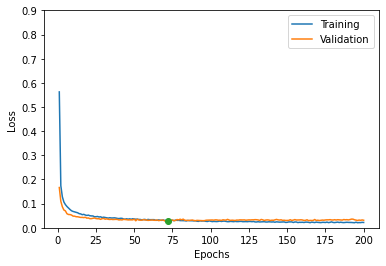

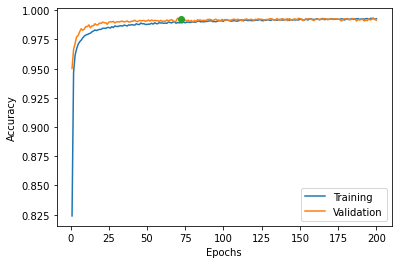

In [195]:
x_plot = list(range(1,n_epochs+1))
plot_history(x_plot, network_history, best_epoch)

### Comments



As we can see, the model converges quickly, and then tends to improve very slowly. This is the best result I was able to obtain with this configuration, as with lower learning rates the convergence was slower, while with higher learning rates we had a strong instability.
In general, the two curves tend to be very close together, and therefore there is not a strong sign of overfitting.

## Validate the model and comment the results

### Performance metrics

####Training set

In [196]:
score_opt = best_model.model.evaluate(X_train, Y_train, batch_size=128, verbose=0)
print("Training loss: ", score_opt[0])
print("Training accuracy: ", score_opt[1])

Training loss:  0.005156494677066803
Training accuracy:  0.9986851811408997


In [197]:
predictions_opt = best_model.model.predict(X_train)
y_classes_opt = np.round(predictions_opt).astype(np.int8)
print(classification_report(y_classes_opt, Y_train, digits=5))

              precision    recall  f1-score   support

           0    0.99981   1.00000   0.99991      5347
           1    0.99918   0.99852   0.99885      6075
           2    0.99925   0.99963   0.99944      5335
           3    0.99819   0.99964   0.99891      5524
           4    0.99753   0.99829   0.99791      5253
           5    0.99856   0.99877   0.99867      4877
           6    1.00000   0.99888   0.99944      5341
           7    0.99876   0.99806   0.99841      5672
           8    0.99735   0.99943   0.99839      5263
           9    0.99736   0.99623   0.99679      5306

   micro avg    0.99861   0.99874   0.99868     53993
   macro avg    0.99860   0.99874   0.99867     53993
weighted avg    0.99861   0.99874   0.99868     53993
 samples avg    0.99861   0.99861   0.99861     53993



####Validation set

In [198]:
score_opt = best_model.model.evaluate(X_val, Y_val, batch_size=128, verbose=0)
print("Validation loss: ", score_opt[0])
print("Validation accuracy: ", score_opt[1])

Validation loss:  0.031220274046063423
Validation accuracy:  0.9915000200271606


In [199]:
predictions_opt = best_model.model.predict(X_val)
y_classes_opt = np.round(predictions_opt).astype(np.int8)
print(classification_report(y_classes_opt, Y_val, digits=5))

              precision    recall  f1-score   support

           0    0.99652   0.99307   0.99479       577
           1    0.99702   0.98964   0.99332       676
           2    0.98551   0.99190   0.98869       617
           3    0.98831   0.99329   0.99079       596
           4    0.99316   0.99147   0.99231       586
           5    0.99448   0.98901   0.99174       546
           6    0.99485   0.99828   0.99656       581
           7    0.98827   0.98827   0.98827       597
           8    0.98960   0.99304   0.99132       575
           9    0.98767   0.98920   0.98843       648

   micro avg    0.99150   0.99167   0.99158      5999
   macro avg    0.99154   0.99172   0.99162      5999
weighted avg    0.99151   0.99167   0.99158      5999
 samples avg    0.99150   0.99150   0.99150      5999



####Test set

In [200]:
score_opt = best_model.model.evaluate(X_test, Y_test, batch_size=128, verbose=0)
print("Test loss: ", score_opt[0])
print("Test accuracy: ", score_opt[1])

Test loss:  0.02680101990699768
Test accuracy:  0.9923999905586243


In [201]:
predictions_opt = best_model.model.predict(X_test)
y_classes_opt = np.round(predictions_opt).astype(np.int8)
print(classification_report(y_classes_opt, Y_test, digits=5))

              precision    recall  f1-score   support

           0    0.99286   0.99591   0.99438       977
           1    0.99736   0.99211   0.99473      1141
           2    0.98837   0.98933   0.98885      1031
           3    0.99505   0.99702   0.99604      1008
           4    0.99084   0.99591   0.99336       977
           5    0.99552   0.99329   0.99440       894
           6    0.98852   0.99266   0.99059       954
           7    0.98930   0.98930   0.98930      1028
           8    0.99076   0.99178   0.99127       973
           9    0.98910   0.99106   0.99008      1007

   micro avg    0.99180   0.99279   0.99230      9990
   macro avg    0.99177   0.99284   0.99230      9990
weighted avg    0.99181   0.99279   0.99230      9990
 samples avg    0.99180   0.99180   0.99180      9990



#### Comments

As we can see, the performances are very good both in training and in validation or test sets. In fact we have for the training set an accuracy of 99.87%, and an accuracy of 99.15% and 99.24% respectively for. The model, despite having a slight overfitting on the training set, seems to have a good generalization capacity.

For f1-score, since the classes are fairly balanced, both weighted avg and micro avg are a good general measure metric. Since we have f1-score results similar to those of accuracy, we can make the same conclusions.